# v0.3 - Exp1
Playing with Encoder-Decoder size:

Config,    SacreBLEU,     chrF
- 4/8 : 23.40, 0.4818
- 6/6 : 24.2197 0.48809
- 7/5 :  24.3894, 0.4879
- 8/4 : 23.1264, 
- 9/3 :  23.597 ,0.4765 
- 10/2 : 23.284 , 0.4697
- 11/1 : 0.0042, 0.1158

- 6/6, 42, 25.2287, 0.4923
- 6/6, 1918, 24.175, 0.4799
- 6/6, 87, 24.17, 0.4799

- 4/8, 42, 23.4018, 0.4818
- 4/8, 1918, 23.9568, 0.4866

In [1]:
from fastai2.text.all import *
from fastai2.callback.all import *
from fastai2.basics import *
import seaborn as sns
import sacrebleu
from nlp import load_dataset

from einops import rearrange
import gc
import csv

In [2]:
import wandb
from wandb.wandb_config import ConfigError

wandb.init()

W&B Run: https://app.wandb.ai/morgan/antra-nbs/runs/z0msu4pt

In [3]:
from fastai2.callback.wandb import *

In [4]:
path = Path('data/irish/parallel_corpora/paracrawl')
fn = 'para_crawl_huggingface_clean_v02_20200723.csv'

## Paired t-test approach

https://forums.fast.ai/t/how-to-do-statistical-test-to-show-significant-improvement/76038/7

## Experiment Seed

In [5]:
#seed=42  # 1918, 139
#seed=1918
seed=87

def seed_everything(seed):
    # Python
    os.environ['PYTHONHASHSEED'] = str(seed)

    #pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    #numpy
    np.random.seed(seed)

    # fastai
    set_seed(seed)
    
seed_everything(seed)

## Experiment Number

In [6]:
exp = '1'

### Load saved dataset

In [7]:
df=pd.read_csv(path/fn)
print(len(df))
df.head()

357399


,en,ga,clean
0,"Among the French PIM , in 2013, it is only 9 islands that have been chiroptérologiques inventories .","I measc na PIM Fraince, i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail.",True
1,"Among the French PIM, in 2013, it is only 9 islands that have been chiroptérologiques inventories.","I measc na PIM Fraince , i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail .",True
2,"Among the French PIM, in 2013, it is only 9 islands that have been chiroptérologiques inventories.","I measc na PIM Fraince, i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail.",True
3,"As you can see, so get to show off the spacious shapes in 3D (red and blue).","Mar is féidir leat a fheiceáil, a fháil mar sin a thaispeáint as na cruthanna mhór i 3D (dearg agus gorm).",True
4,"Equation Solving – Traditional, simple","Ligningsløsning – Traidisiúnta, simplí",True


# RAISE BUG

In [8]:
path = Path('data/irish/parallel_corpora/paracrawl')
fn = 'para_crawl_huggingface_clean_v02_20200723.csv'

In [9]:
# ds_dict = load_dataset('csv', data_files=str(path/fn),
#                   description='en-ga Paracrawl data from HuggingFace, clean for suspect translations',
#                       download_mode='force_redownload', version='0.0.2')
ds_dict = load_dataset('csv', data_files=str(path/fn),
                  description='en-ga Paracrawl data from HuggingFace, clean for suspect translations',
                    version='0.0.1')
ds=ds_dict['train']

Using custom data configuration default


Remove columns that were identified as noisy

In [10]:
def is_clean(example): return example['clean']
print(len(ds))
ds = ds.filter(is_clean)
print(len(ds))

357399
355837


### Pre-processing

**Remove long texts to make things easier**

In [11]:
# df['ga_len'] = df['ga'].str.split().str.len()
# df['en_len'] = df['en'].str.split().str.len()

Get sample lengths

In [12]:
def get_lens(example, lang):
    example[f'{lang}_len'] = len(example[lang].split())
    return example

ds = ds.map(partial(get_lens, lang='ga'))
ds = ds.map(partial(get_lens, lang='en'))
ds

Dataset(features: {'clean': Value(dtype='bool', id=None), 'en': Value(dtype='string', id=None), 'en_len': Value(dtype='int64', id=None), 'ga': Value(dtype='string', id=None), 'ga_len': Value(dtype='int64', id=None)}, num_rows: 355837)

In [13]:
# Word count 90th percentile
np.percentile([o for o in ds['ga_len']], 90), np.percentile([o for o in ds['en_len']], 90)

(49.0, 47.0)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1504fe2350>, 18.0)

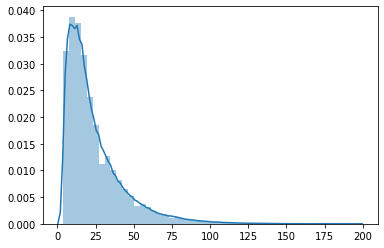

In [14]:
sns.distplot(ds['ga_len']), np.median(ds['ga_len'])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1504e377d0>, 17.0)

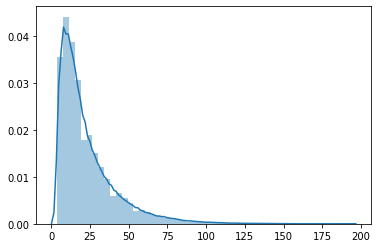

In [15]:
sns.distplot(ds['en_len']), np.median(ds['en_len'])

In [16]:
def len_filter(example,col,l): 
    return example[col] <= l

print(len(ds))
ds = ds.filter(partial(len_filter, col='ga_len', l=60))
ds = ds.filter(partial(len_filter, col='en_len', l=60))
print(len(ds))

355837
334244


In [17]:
# print(f'Removing {len(df.query("en_len > 60"))} EN samples where len was > 60')
# print(len(df))
# df=df[~df.index.isin(df.query("en_len > 60").index)]
# print(len(df))
      
# print(f'Removing {len(df.query("ga_len > 60"))} FR samples where len was > 60')
# print(len(df))
# df=df[~df.index.isin(df.query("ga_len > 60").index)]
# print(len(df))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1504acf910>, 17.0)

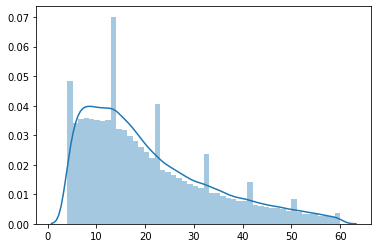

In [18]:
sns.distplot(ds['ga_len']), np.median(ds['ga_len'])

**Lowercase everything**

NOT Done as it is appliced in the rules below

In [19]:
# df['en'] = df['en'].apply(lambda x:x.lower())
# df['ga'] = df['ga'].apply(lambda x:x.lower())

In [20]:
# def lowercase_all(example, lang):
#     example[lang] = example[lang].lower()
#     return example

# ds = ds.map(partial(lowercase_all, lang='ga'))
# ds = ds.map(partial(lowercase_all, lang='en'))
# ds['ga'][400:420]

Rules used as part of tokenization

In [21]:
proc_rules=defaults.text_proc_rules[:-1] + [partial(lowercase, add_eos=True)]
proc_rules

[<function fastai2.text.core.fix_html(x)>,
 <function fastai2.text.core.replace_rep(t)>,
 <function fastai2.text.core.replace_wrep(t)>,
 <function fastai2.text.core.spec_add_spaces(t)>,
 <function fastai2.text.core.rm_useless_spaces(t)>,
 <function fastai2.text.core.replace_all_caps(t)>,
 <function fastai2.text.core.replace_maj(t)>,
 functools.partial(<function lowercase at 0x7f15461128c0>, add_eos=True)]

### Get Dataloaders

Load vocab to speed up data loading

In [22]:
df=ds.data.to_pandas()
df.head()

,clean,en,en_len,ga,ga_len
0,True,"Among the French PIM , in 2013, it is only 9 islands that have been chiroptérologiques inventories .",18,"I measc na PIM Fraince, i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail.",16
1,True,"Among the French PIM, in 2013, it is only 9 islands that have been chiroptérologiques inventories.",16,"I measc na PIM Fraince , i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail .",18
2,True,"Among the French PIM, in 2013, it is only 9 islands that have been chiroptérologiques inventories.",16,"I measc na PIM Fraince, i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail.",16
3,True,"As you can see, so get to show off the spacious shapes in 3D (red and blue).",17,"Mar is féidir leat a fheiceáil, a fháil mar sin a thaispeáint as na cruthanna mhór i 3D (dearg agus gorm).",21
4,True,"Equation Solving – Traditional, simple",5,"Ligningsløsning – Traidisiúnta, simplí",4


In [23]:
#df = df.iloc[:1000]

Modified Tokenizer.from_df to take a lang arguemnt

In [24]:
class Tokenizer(Transform):
    "Provides a consistent `Transform` interface to tokenizers operating on `DataFrame`s and folders"
    input_types = (str, list, L, tuple, Path)
    def __init__(self, tok, rules=None, counter=None, lengths=None, mode=None, sep=' '):
        store_attr(self, 'tok,counter,lengths,mode,sep')
        self.rules = defaults.text_proc_rules if rules is None else rules

    @classmethod
    @delegates(tokenize_df, keep=True)
    def from_df(cls, text_cols, lang='en', tok=None, rules=None, sep=' ', **kwargs):
        if tok is None: tok = WordTokenizer(lang=lang)   # <--- MODIFIED HERE
        res = cls(tok, rules=rules, mode='df')
        res.kwargs,res.train_setup = merge({'tok': tok}, kwargs),False
        res.text_cols,res.sep = text_cols,sep
        return res

    @classmethod
    @delegates(tokenize_folder, keep=True)
    def from_folder(cls, path, tok=None, rules=None, **kwargs):
        path = Path(path)
        if tok is None: tok = WordTokenizer()
        output_dir = tokenize_folder(path, tok=tok, rules=rules, **kwargs)
        res = cls(tok, counter=(output_dir/fn_counter_pkl).load(),
                  lengths=(output_dir/fn_lengths_pkl).load(), rules=rules, mode='folder')
        res.path,res.output_dir = path,output_dir
        return res

    def setups(self, dsets):
        if not self.mode == 'df' or not isinstance(dsets.items, pd.DataFrame): return
        dsets.items,count = tokenize_df(dsets.items, self.text_cols, rules=self.rules, **self.kwargs)
        if self.counter is None: self.counter = count
        return dsets

    def encodes(self, o:Path):
        if self.mode=='folder' and str(o).startswith(str(self.path)):
            tok = self.output_dir/o.relative_to(self.path)
            return L(tok.read().split(' '))
        else: return self._tokenize1(o.read())

    def encodes(self, o:str): return self._tokenize1(o)
    def _tokenize1(self, o): return first(self.tok([compose(*self.rules)(o)]))

    def get_lengths(self, items):
        if self.lengths is None: return None
        if self.mode == 'df':
            if isinstance(items, pd.DataFrame) and 'text_lengths' in items.columns: return items['text_length'].values
        if self.mode == 'folder':
            try:
                res = [self.lengths[str(Path(i).relative_to(self.path))] for i in items]
                if len(res) == len(items): return res
            except: return None

    def decodes(self, o): return TitledStr(self.sep.join(o))

In [25]:
# at 30k tokens per vocab sometimes this works, sometimes it doesn't

# Couldnt process 30k tokens until I added the 'hi' below, it was getting stuck at 94.87%, no idea why
@Numericalize
def encodes(self, o): 
    print('hi')
    return TensorText(tensor([self.o2i  [o_] for o_ in o]))

class floatify_tfm(Transform):
    def encodes(self,o): return o.float()
    def decodes(self,o): return o.long()

max_vocab=30000
#splits = ColSplitter()(df) 
splits = RandomSplitter(valid_pct=0.2, seed=42)(df)

tfms = [[Tokenizer.from_df(text_cols='en' , rules=proc_rules), attrgetter("text"), Numericalize(max_vocab=max_vocab)], 
       [Tokenizer.from_df(text_cols='ga', lang='ga', rules=proc_rules), attrgetter("text"), Numericalize(max_vocab=max_vocab)]]

dl = partial(SortedDL, shuffle=True, res=df.ga_len.values)

dsets = Datasets(df, tfms, splits=splits, dl_type=dl)

# remove the print from Numericalize
@Numericalize
def encodes(self, o): return TensorText(tensor([self.o2i  [o_] for o_ in o]))

hi


hi


In [26]:
# en_vocab=[]
# ga_vocab=[]
# with open(f'paracrawl_vocab_en_exp{exp}.csv', newline='') as csvfile:
#     v_reader = csv.reader(csvfile, delimiter=',')
#     for row in v_reader:
#         en_vocab.append(row[0])
        
# with open(f'paracrawl_vocab_ga_exp{exp}.csv', newline='') as csvfile:
#     v_reader = csv.reader(csvfile, delimiter=',')
#     for row in v_reader:
#         ga_vocab.append(row[0])
        
# len(en_vocab), len(ga_vocab), en_vocab[:10], ga_vocab[:10]

In [27]:
len(dsets), splits, len(dsets[2][0]), len(dsets[2][1]), dsets[2]

(334244,
 ((#267396) [142788,143864,71475,232172,136743,17163,145516,163557,296155,19037...],
  (#66848) [255414,148963,186606,40380,28590,6799,259930,188378,286014,4807...]),
 24,
 23,
 (TensorText([    2,     8,  1018,     9,     8,  2104,     7,  7176,    11,    16,
            821,    11,    50,    23,   189,   165,  3062,    32,    60,    92,
          19526,  8919,    14,     3]),
  TensorText([    2,    17,   757,    18,     7,  9046,     8,  2425,    10,    17,
            832,    10,    58,    43,    82,   194,  4016,     9,   135, 29410,
           7653,    14,     3])))

In [28]:
bs,sl = 32, 512
dls = dsets.dataloaders(bs=bs, seq_len=sl, before_batch=partial(pad_input, pad_fields=[0,1]))
dls.show_batch()

,text,text_
0,"xxbos ( i ) the application of any goods of a kind specified in the xxmaj fourth xxmaj schedule by a person for the purposes of his business and treated as delivered in accordance with section 3 ( 1 ) ( e ) , xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","xxbos ( i ) le duine do bhaint úsáid chun críocha a ghnó as aon earraí de chineál a shonraítear sa xxmaj cheathrú xxmaj sceideal agus a áirítear mar earraí arna seachadadh de réir alt 3 ( 1 ) ( e ) , xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
1,"xxbos xxmaj this he did in the service of justice , to spread the xxmaj good xxmaj news that xxmaj jesus is xxmaj lord and xxmaj savior of all people . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","xxbos xxmaj seo rinne sé i seirbhís an cheartais , a scaipeadh ar an xxmaj soiscéal go bhfuil an xxmaj tiarna íosa agus xxmaj xxunk gach duine . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
2,"xxbos 2 . — sub - section ( 1 ) of section 5 of the xxmaj principal xxmaj act is hereby amended in the following respects and the said section shall be construed and have effect accordingly , that is to say : — xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","xxbos 2 . — deintear leis seo fo - alt ( 1 ) d'alt 5 den phríomh - acht do leasú ar na slite seo leanas agus léireofar an t - alt san agus beidh éifeacht aige dá réir sin , sé sin le rá : — xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
3,xxbos xxunk rattan weave chair and table xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,xxbos xxunk ratáncomment xxunk chathaoirleach agus tábla xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad
4,xxbos xxmaj site xxmaj notice of xxmaj further xxmaj information / xxmaj revised xxmaj plans ( document ) xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,xxbos xxmaj fógra xxmaj láithreáin maidir le xxmaj faisnéis xxmaj bhreise / xxmaj pleananna xxmaj athbhreithnithe ( form ) xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad
5,xxbos xxmaj this led to xxmaj rwanda was a period of relative stability and economic growth until the late 1980s . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,xxbos xxmaj mar thoradh air seo xxmaj ruanda xxmaj bhí am na cobhsaíochta coibhneasta agus fás eacnamaíoc

Save vocab to speed up data loading

In [29]:
# with open(f'models/paracrawl_vocab_en_v0.2_exp{exp}.csv', 'w', newline='') as csvfile:
#     v_writer = csv.writer(csvfile, delimiter=',')
#     for l in dls.vocab[0]:
#         v_writer.writerow([l])
        
# with open(f'models/paracrawl_vocab_ga_v0.2_exp{exp}.csv', 'w', newline='') as csvfile:
#     v_writer = csv.writer(csvfile, delimiter=',')
#     for l in dls.vocab[1]:
#         v_writer.writerow([l])

In [30]:
len(dls.train_ds)+len(dls.valid_ds), len(dls.train), len(dls.valid)

(334244, 8356, 2089)

In [31]:
print(f'Vocab lengths are : {len(dls.vocab[0]), len(dls.vocab[1])}')

Vocab lengths are : (22952, 30008)


In [32]:
o=dls.one_batch(); o[0].size(), o[1].size(), o

(torch.Size([32, 65]),
 torch.Size([32, 75]),
 (TensorText([[   2,   13,   57,  ...,    1,    1,    1],
          [   2,    8,  129,  ...,    1,    1,    1],
          [   2,    8,    9,  ...,    1,    1,    1],
          ...,
          [   2,   13,  287,  ...,  382,   14,    3],
          [   2,   13,   57,  ...,    1,    1,    1],
          [   2,    8, 1073,  ...,    1,    1,    1]], device='cuda:0'),
  TensorText([[  2,  12,  17,  ...,   1,   1,   1],
          [  2,   8,  11,  ...,   1,   1,   1],
          [  2,   8,  31,  ...,   1,   1,   1],
          ...,
          [  2,  12, 297,  ...,   1,   1,   1],
          [  2,  12,  17,  ...,   1,   1,   1],
          [  2,   8, 844,  ...,   1,   1,   1]], device='cuda:0')))

## Transformer model

In [33]:
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos):
        #inp = torch.ger(pos, self.freq)
        inp = torch.ger(pos, self.freq.float())
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

In [34]:
# tst_encoding = PositionalEncoding(20)
# res = tst_encoding(torch.arange(0,100).float())
# _, ax = plt.subplots(1,1)
# for i in range(1,5): ax.plot(res[:,i])

In [35]:
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = Embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        #pos = torch.arange(0, inp.size(1), device=inp.device).float()     
        pos = torch.arange(0, inp.size(1), device=inp.device).float()     
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

## PyTorch Transformer Simple

Note: [src/tgt/memory]_mask should be filled with float(‘-inf’) for the masked positions and float(0.0) else. These masks ensure that predictions for position i depend only on the unmasked positions j and are applied identically for each sequence in a batch. 

[src/tgt/memory]_key_padding_mask should be a ByteTensor where True values are positions that should be masked with float(‘-inf’) and False values will be unchanged. This mask ensures that no information will be taken from position i if it is masked, and has a separate mask for each sequence in a batch.

attn mask with -inf
key_padding mask with True

### pt_Transformer

In [36]:
def to_half(b):
    "Recursively map lists of tensors in `b ` to FP16."
    return apply(lambda x: x.half() if torch.is_floating_point(x) else x, b)

In [37]:
class pt_Transformer(Module):
    def __init__(self, src_vcbsz, trg_vcbsz, n_enc_layers=6, n_dec_layers=6, n_heads=8, d_model=256, d_head=32, 
                 d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1, fp16=True):
        self.pad_idx = pad_idx
        self.enc_tfmr_emb = TransformerEmbedding(src_vcbsz, d_model, p)
        self.dec_tfmr_emb = TransformerEmbedding(trg_vcbsz, d_model, 0.)        
        self.final = nn.Linear(d_model, trg_vcbsz)
        self.fp16 = fp16
        # !!!
        #self.final.weight = self.dec_tfmr_emb.embed.weight    # !! Ties weights
        
        self.transformer_model=torch.nn.Transformer(d_model=d_model, nhead=n_heads, num_encoder_layers=n_enc_layers, 
                                   num_decoder_layers=n_dec_layers, dim_feedforward=d_inner, dropout=p, 
                                   activation='relu', custom_encoder=None, custom_decoder=None)
    
    
    def forward(self, src, trg, src_mask=None, tgt_mask=None, memory_mask=None, 
                        src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        
        enc_emb, dec_emb = self.enc_tfmr_emb(src), self.dec_tfmr_emb(trg)
        
        # Test whether fp16 is being used or not
#         if not isinstance(model.transformer_model.encoder.layers[0].self_attn.out_proj.weight,
#                           torch.cuda.FloatTensor):
        if model.transformer_model.encoder.layers[0].self_attn.out_proj.weight.dtype == torch.float16:
            enc_emb=to_half(enc_emb)
            dec_emb=to_half(dec_emb)
        
        if src.device.type == 'cuda':
            src_mask=self.transformer_model.generate_square_subsequent_mask(src.size(1)).cuda()
            trg_mask=self.transformer_model.generate_square_subsequent_mask(trg.size(1)).cuda()
        else:
            src_mask=self.transformer_model.generate_square_subsequent_mask(src.size(1)).cpu()
            trg_mask=self.transformer_model.generate_square_subsequent_mask(trg.size(1)).cpu()
        
        dec_out = self.transformer_model(enc_emb.permute(1,0,2), dec_emb.permute(1,0,2),
                                         src_mask=src_mask, tgt_mask=trg_mask, memory_mask=None, 
                        src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None)
        
        out=self.final(dec_out)
        
        return out.permute(1,0,2)

### Callbacks

#### Present Input and Target in a single tuple

In [38]:
class CombineInputOutputCallback(Callback):
    '''Callback to combine the input and target text into self.xb'''
    def __init__(self): pass
    def begin_batch(self): 
        self.learn.xb = (self.xb[0], self.yb[0])

Shifting and masking of y, from [Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html#training):

> We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position i can depend only on the known outputs at positions less than i.

#### Shifting

#### Target shift/offset explained

**Taken from [@bentrevett's brilliant github repo "pytorch-seq2seq" tutorials](https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb):**

As we want our model to predict the <eos> token but not have it be an input into our model we simply slice the <eos> token off the end of the sequence. Thus:

$$\begin{align*}\text{trg} &= [sos, x_1, x_2, x_3, eos]\\\text{trg[:-1]} &= [sos, x_1, x_2, x_3]\end{align*}$$

$x_i$ denotes **actual** target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the <eos> token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes **predicted** target sequence element. We then calculate our loss using the original trg tensor with the <sos> token sliced off the front, leaving the <eos> token:

$$\begin{align*} \text{output} &= [y_1, y_2, y_3, eos]\\ \text{trg[1:]} &= [x_1, x_2, x_3, eos] \end{align*}$$

We then calculate our losses and update our parameters as is standard.
    
    
We don't want to punish the model for not translating the 'sos' token, but we do need it to predict/define the end of the sentence

**RemoveEOSCallback** 

Cut the *EOS* token token from the **output_x** presented to the model as we are trying to predict the next word. Therefore don't want to model to try anything after the *EOS* token. So the last token given to the model will be the token before *EOS*. This callback modifies the second element of our learn.xb, (which is the *copied* yb)

But this should also ignore padding, as otherwise we'll be just cutting the last padding token and not the EOS

In [39]:
class RemoveEOSCallback(Callback):
    '''
        Shift the target presented to the model during training to remove the "eos" token as 
        we don't want the model to learn to translate EOS when it sees EOS.
        
        In practice we actually mask the EOS token as due to batching the last token will often be a <pad> token,
        not EOS
    '''
    def __init__(self, eos_idx): self.eos_idx=eos_idx
    def begin_batch(self):        
        eos_mask=(self.learn.xb[1]!=self.eos_idx)
        sz=torch.tensor(self.learn.xb[1].size())
        sz[1]=sz[1]-1
        self.learn.xb = (self.learn.xb[0], self.learn.xb[1][eos_mask].view((sz[0],sz[1])))

**LossTargetShiftCallback:** Shift the target shown to the loss to exclude the "eos" token, as translating "bos" is not part of our language translation objective

In [40]:
class LossTargetShiftCallback(Callback):
    '''
        Shift the target shown to the loss to exclude the "bos" token as the first token we want predicted
        should be an actual word, not the "bos" token (as we have already given the model "bos" )
    '''
    def __init__(self): pass
    def after_pred(self): 
        self.learn.yb = (self.learn.yb[0][:,1:],)

### Model

Transformer size from Annotated Transformer:

N=6, d_model=512, d_ff=2048, h=8

In [41]:
pad_idx=1
assert dls.vocab[1][pad_idx] == 'xxpad' 
n_x_vocab, n_y_vocab = len(dls.vocab[0]), len(dls.vocab[1])
d_model=512
n_heads=8 #12
d_inner=2048  #1024

n_enc_layers=4
n_dec_layers=8

model=pt_Transformer(src_vcbsz=n_x_vocab, trg_vcbsz=n_y_vocab, d_model=d_model, d_inner=d_inner,
                    n_enc_layers=n_enc_layers, n_dec_layers=n_dec_layers)

In [42]:
#model

Kaiming_Normal works terrribly, at least if you apply it to everything except LayerNorm...

DistilBERT works ok

Could try xavier:

```
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);
```

**DistilBERT initialisation**

In [43]:
# DistilERT HF init weights https://github.com/huggingface/transformers/blob/31e67dd19f1b3fe2bc9a13f86d814f3f7bba48e4/src/transformers/modeling_distilbert.py

def distil_apply_leaf(m, f):
    "Apply `f` to children of `m`."
    c = m.children()
    if isinstance(m, nn.Module): f(m)
    for l in c: apply_leaf(l,f)


def _distilbert_init_weights(module):
    """ Initialize the weights.
    """
    if isinstance(module, nn.Embedding):
        if module.weight.requires_grad:
            module.weight.data.normal_(mean=0.0, std=0.02) #std=self.config.initializer_range)
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=0.02) #self.config.initializer_range)
    elif isinstance(module, nn.LayerNorm):
        module.bias.data.zero_()
        module.weight.data.fill_(1.0)
    if isinstance(module, nn.Linear) and module.bias is not None:
        module.bias.data.zero_()

distil_apply_leaf(model, _distilbert_init_weights)

In [44]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 88,753,464 trainable parameters


### Learner

In [45]:
class WandbLogNumLayers(Callback):
    run_after=WandbCallback
    def begin_fit(self):
        wandb.config.update({'n_enc_layers':n_enc_layers, 'n_dec_layers':n_dec_layers})

# Make sure model config is logged each time        
WandbCallback._wandb_watch_called=False

In [46]:
cbs = [CombineInputOutputCallback, RemoveEOSCallback(eos_idx=3), LossTargetShiftCallback, 
       WandbLogNumLayers, WandbCallback(log_preds=False)] 

pad_idx=1
assert dls.vocab[1][pad_idx] == 'xxpad' 
loss_func = CrossEntropyLossFlat(ignore_index=pad_idx)

# No accuracy metric
learn = Learner(dls, model, metrics=[Perplexity(), CorpusBLEUMetric(vocab_sz=n_y_vocab)], 
                cbs=cbs, loss_func=loss_func).to_fp16()

In [47]:
#learn.load('paracrawl_en_ga_5e_5e-4_5e_1e-5_v0.2_exp4')

In [48]:
# from fastai2.fp16_utils import convert_network
# learn.model = convert_network(learn.model, dtype=torch.float32)
# learn.save('paracrawl_en_ga_5e_5e-4_5e_1e-5_v0.2_exp4_no_opt', with_opt=False)

In [49]:
# learn=learn.to_fp32()
# learn.save('paracrawl_en_ga_5e_5e-4_5e_1e-5_v0.2_exp4_no_opt', with_opt=False)

v0.2, exp4 metrics: 0.5493	   0.824	    0.611	   2.281	   0.499

v0.3, exp1 metrics (4/8):  0.557328	0.806217	2.239420	0.50106  **SacreBLEU: 23.40 chrF: 0.4818**

v0.3, exp1 metrics (6/6):  0.559948	0.818831	2.267846	0.49978  **SacreBLEU: 24.2197 chrF: 0.48809**

v0.3, exp1 metrics (7/5):  0.555146	0.822733	2.276713	0.498889   **SacreBLEU: 24.3894 chrF: 0.4879**

v0.3, exp1 metrics (8/4): 0.598	        0.846            2.331	        0.494    **SacreBLEU: 23.1264**

v0.3, exp1 metrics (9/3): 0.602691	0.869712	2.386224	0.489849    **SacreBLEU: 23.597 ,chrF: 0.4765 **

v0.3, exp1 metrics (10/2):  0.654769	0.910338	2.485163	0.4820    **SacreBLEU: 23.284 , chrF 46.97**

v0.3, exp1 metrics (11/1):   2.504184	3.014412	20.377104	0.164695   **SacreBLEU: 0.0042, chrF 11.58**

# Training

### 11/1

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.3630780577659607)

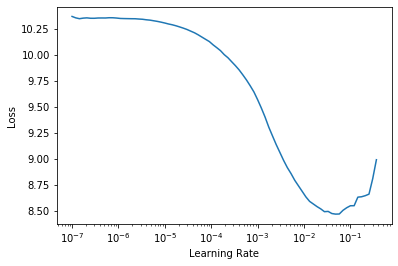

In [49]:
learn.lr_find()

In [50]:
learn.fit_one_cycle(5, 5e-4, div=5)

epoch,train_loss,valid_loss,perplexity,corpus_bleu,time
0,3.317100,3.426797,30.777901,0.118568,15:55
1,2.934192,3.252898,25.865183,0.136730,15:58
2,2.696043,3.129567,22.864080,0.150270,15:50
3,2.519069,3.050292,21.121506,0.161016,15:43
4,2.504184,3.014412,20.377104,0.164695,16:01


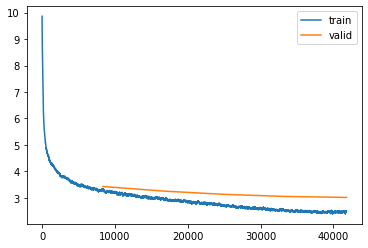

In [51]:
learn.recorder.plot_loss()

### 10/2

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.5248074531555176)

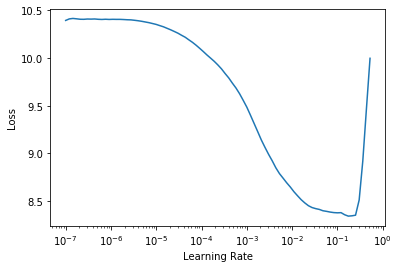

In [49]:
learn.lr_find()

In [50]:
learn.fit_one_cycle(5, 5e-4, div=5)

epoch,train_loss,valid_loss,perplexity,corpus_bleu,time
0,1.741093,1.727088,5.624251,0.335119,16:08
1,1.225455,1.302555,3.678684,0.400621,15:53
2,0.945482,1.090714,2.976398,0.440837,15:47
3,0.702999,0.950254,2.586368,0.471814,15:57
4,0.654769,0.910338,2.485163,0.482091,15:59


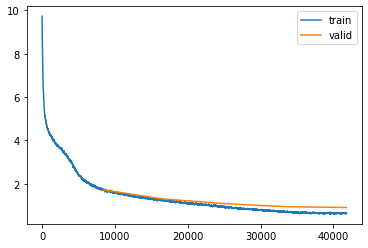

In [51]:
learn.recorder.plot_loss()

### 9/3

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.5248074531555176)

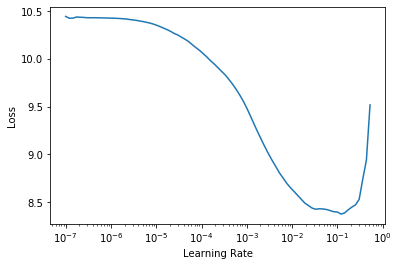

In [49]:
learn.lr_find()

In [50]:
learn.fit_one_cycle(5, 5e-4, div=5)

epoch,train_loss,valid_loss,perplexity,corpus_bleu,time
0,1.647673,1.645906,5.185707,0.344530,16:30
1,1.191012,1.265134,3.543569,0.405127,16:11
2,0.919154,1.050843,2.860060,0.448763,16:11
3,0.668536,0.906408,2.475414,0.480521,16:21
4,0.602691,0.869712,2.386224,0.489849,16:18


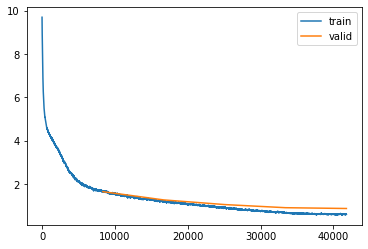

In [51]:
learn.recorder.plot_loss()

### 8/4

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.5248074531555176)

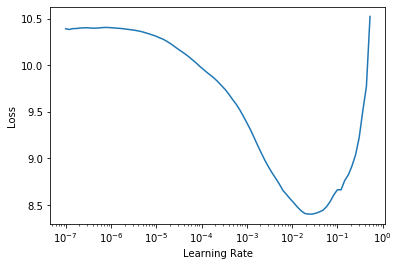

In [49]:
learn.lr_find()

In [50]:
learn.fit_one_cycle(5, 5e-4, div=5)

epoch,train_loss,valid_loss,perplexity,corpus_bleu,time
0,1.596710,1.620129,5.053741,0.350061,16:59
1,1.187164,1.223218,3.398104,0.410913,16:57
2,0.861979,1.025397,2.788202,0.452798,16:54
3,0.664985,0.882189,2.416184,0.484972,17:02
4,0.598704,0.846599,2.331703,0.494229,16:41


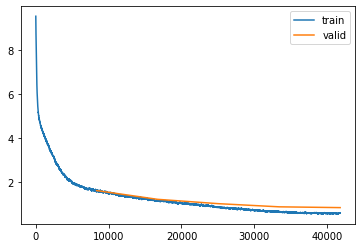

In [51]:
learn.recorder.plot_loss()

In [56]:
learn.save('paracrawl_en_ga_5e_5e-4_v0.3_exp{exp}')

In [53]:
#learn.load('paracrawl_en_ga_5e_5e-4_v0.2_exp{exp}')

### 7/5

In [65]:
#learn.lr_find()

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.6309573650360107)

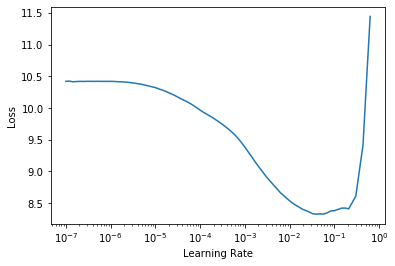

In [114]:
learn.lr_find()

In [115]:
learn.fit_one_cycle(5, 5e-4, div=5)

epoch,train_loss,valid_loss,perplexity,corpus_bleu,time
0,1.591581,1.574129,4.826536,0.357226,17:09
1,1.120346,1.198534,3.315253,0.416058,17:09
2,0.866068,0.987402,2.684252,0.458354,16:59
3,0.630376,0.851692,2.343609,0.489811,17:09
4,0.555146,0.822733,2.276713,0.498889,16:55


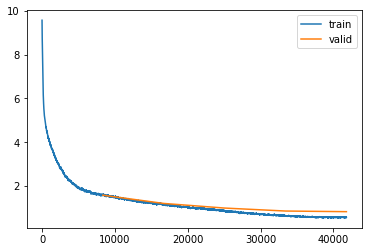

In [116]:
learn.recorder.plot_loss()

### 6/6

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.5248074531555176)

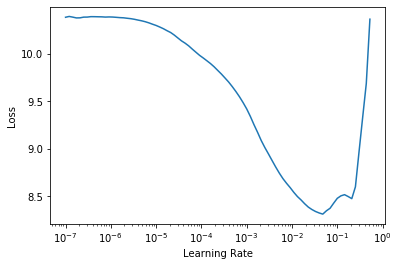

In [53]:
learn.lr_find()

In [54]:
learn.fit_one_cycle(5, 5e-4, div=5)

epoch,train_loss,valid_loss,perplexity,corpus_bleu,time
0,1.581651,1.581467,4.862083,0.356081,17:35
1,1.163126,1.225068,3.404398,0.412044,17:11
2,0.862173,0.986448,2.681693,0.459008,17:33
3,0.623065,0.851799,2.343860,0.490558,17:15
4,0.559948,0.818831,2.267846,0.499789,17:03


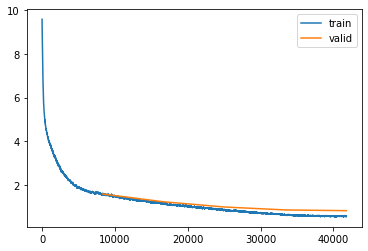

In [55]:
learn.recorder.plot_loss()

### 4/8

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.6309573650360107)

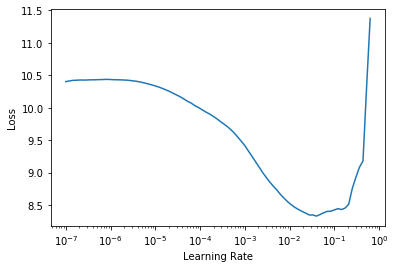

In [46]:
learn.lr_find()

In [47]:
learn.fit_one_cycle(5, 5e-4, div=5)

epoch,train_loss,valid_loss,perplexity,corpus_bleu,time
0,1.515814,1.548914,4.706358,0.353537,18:19
1,1.137712,1.191796,3.292989,0.414569,17:44
2,0.818360,0.982700,2.671661,0.459213,18:15
3,0.636549,0.842338,2.321790,0.491275,18:09
4,0.557328,0.806217,2.239420,0.501066,17:44


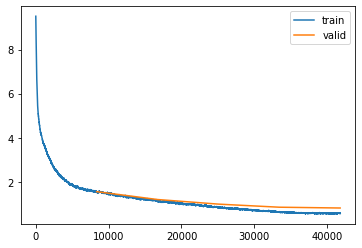

In [48]:
learn.recorder.plot_loss()

## Paired Tests

Testing
- 6/6
- 4/8
- 3/9

### 6/6

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.7585775852203369)

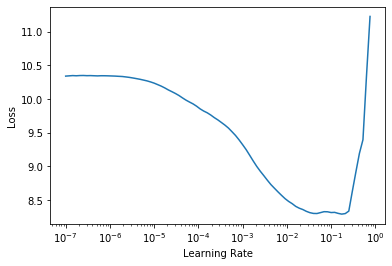

In [50]:
learn.lr_find()

In [ ]:
0.572307	0.822243	2.275598	0.499912
0.548821	0.794450	2.213224	0.502180  (better loss, worse BLEU, chrF)
0.548821	0.794450	2.213224	0.502180	

In [51]:
learn.fit_one_cycle(5, 5e-4, div=5)  # seed 42

epoch,train_loss,valid_loss,perplexity,corpus_bleu,time
0,1.541906,1.552149,4.721607,0.357832,17:27
1,1.163122,1.223086,3.397657,0.410796,17:11
2,0.855861,0.996489,2.708753,0.458580,17:32
3,0.638775,0.856711,2.355400,0.490083,17:11
4,0.572307,0.822243,2.275598,0.499912,17:34


In [47]:
learn.fit_one_cycle(5, 5e-4, div=5)

epoch,train_loss,valid_loss,perplexity,corpus_bleu,time
0,1.560164,1.590466,4.906035,0.351726,17:05
1,1.135612,1.194895,3.303210,0.413596,17:28
2,0.845237,0.972747,2.645200,0.459206,17:12
3,0.619374,0.832921,2.300028,0.492208,17:01
4,0.548821,0.794450,2.213224,0.502180,17:04


In [49]:
learn.fit_one_cycle(5, 5e-4, div=5)

epoch,train_loss,valid_loss,perplexity,corpus_bleu,time
0,1.560164,1.590466,4.906035,0.351726,16:50
1,1.135612,1.194895,3.303210,0.413596,17:16
2,0.845237,0.972747,2.645200,0.459206,17:20
3,0.619374,0.832921,2.300028,0.492208,17:22
4,0.548821,0.794450,2.213224,0.502180,17:01


### 4/8

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.6309573650360107)

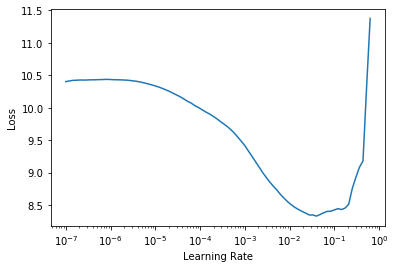

In [46]:
learn.lr_find()

In [ ]:
0.557328	0.806217	2.239420	0.501066	
0.549099	0.810226	2.248415	0.501775	

In [47]:
learn.fit_one_cycle(5, 5e-4, div=5)

epoch,train_loss,valid_loss,perplexity,corpus_bleu,time
0,1.515814,1.548914,4.706358,0.353537,18:14
1,1.137712,1.191796,3.292989,0.414569,18:20
2,0.818360,0.982700,2.671661,0.459213,18:13
3,0.636549,0.842338,2.321790,0.491275,18:07
4,0.557328,0.806217,2.239420,0.501066,18:23


In [47]:
learn.fit_one_cycle(5, 5e-4, div=5)

epoch,train_loss,valid_loss,perplexity,corpus_bleu,time
0,1.553868,1.523222,4.586982,0.359209,17:45
1,1.148244,1.185807,3.273327,0.414078,18:17
2,0.862250,0.972841,2.645449,0.460695,18:09
3,0.638855,0.846233,2.330849,0.491682,18:10
4,0.549099,0.810226,2.248415,0.501775,18:13


In [ ]:
learn.fit_one_cycle(5, 5e-4, div=5)

epoch,train_loss,valid_loss,perplexity,corpus_bleu,time
0,1.553868,1.523222,4.586982,0.359209,17:45
1,1.148244,1.185807,3.273327,0.414078,18:07
2,0.862250,0.972841,2.645449,0.460695,18:27


### 8/4

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 5e-4, div=5)

In [ ]:
learn.fit_one_cycle(5, 5e-4, div=5)

In [ ]:
learn.fit_one_cycle(5, 5e-4, div=5)

#### Generate and Process Translations funcs

In [ ]:
def generate(model, sentence, vocab, to_cuda=True):    
    model=model.eval()
    
    sentence=learn.dls.tokenizer[0].encodes(sentence)
    #sentence=learn.dls.tokenizer[0][1].encodes(sentence)
    sentence=learn.dls.numericalize[0].encodes(sentence)
    
    translated_sentence = [2] 
    i = 0
    while int(translated_sentence[-1]) != 3 and i < 75:   
        if to_cuda: output = forward_model(model, sentence, translated_sentence, to_cuda).cuda()
        else: output = forward_model(model, sentence, translated_sentence, to_cuda).cpu()
        values, indices = torch.topk(output, 5)
        translated_sentence.append(int(indices[-1][0]))
        i+=1

    detok_translated_sentence=detokenize(translated_sentence, vocab)
    #print(' '.join(detok_translated_sentence))
    return ' '.join(detok_translated_sentence)
    

def forward_model(model, src, tgt, to_cuda=True):
    if to_cuda:
        src = torch.as_tensor(src).unsqueeze(0).long().cuda()
        tgt = torch.as_tensor(tgt).unsqueeze(0).cuda()
        tgt_mask = gen_nopeek_mask(tgt.shape[1]).cuda()
        src = to_half(src)
        tgt = to_half(tgt)
    else:
        src = torch.as_tensor(src).unsqueeze(0).long().cpu()
        tgt = torch.as_tensor(tgt).unsqueeze(0).cpu()
        tgt_mask = gen_nopeek_mask(tgt.shape[1]).cpu()
#         src = to_half(src)
#         tgt = to_half(tgt)
    output = model.forward(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None)

    #return output.squeeze(0).to('cpu')
    return output.squeeze(0).detach()


# def tokenize(sentence, freq_list, lang_model):
#     punctuation = ['(', ')', ':', '"', ' ']

#     sentence = sentence.lower()
#     sentence = [tok.text for tok in lang_model.tokenizer(sentence) if tok.text not in punctuation]
#     return [freq_list[word] if word in freq_list else freq_list['[OOV]'] for word in sentence]


def detokenize(sentence, vocab):
    #freq_list = {v: k for k, v in freq_list.items()}
    return [vocab[token] for token in sentence]
    #return [freq_list[token] for token in sentence]
# def detokenize(sentence, freq_list):
#     freq_list = {v: k for k, v in freq_list.items()}
#     return [freq_list[token] for token in sentence]


def gen_nopeek_mask(length):
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, 'h w -> w h')
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [ ]:
def process_trans(trans):
    trans_ls=[]
    for s in trans: 
        #print(s)
        tmp = s.replace('xxbos','')
        tmp = tmp.replace('xxeos','')
        tmp = tmp.replace(' .','.')
        tmp = tmp.replace(' ,',',')
        tmp = tmp.replace(' ?','?')
        tmp = tmp.replace(' !','!')
        #print(tmp[0])
        if tmp.endswith('. '): tmp=tmp[:-1]
        if tmp.endswith('? '): tmp=tmp[:-1]
        if tmp.endswith('! '): tmp=tmp[:-1]
        
        for spec in ['xxmaj ', 'xxup ']:
            found=[]
            for m in re.finditer(spec, tmp):
                found.append(m.start())

            for f in found:
                m = tmp.find(spec)
                if m != -1:   
                    ml = m+len(spec)
                    if m != 0:
                        tmp = tmp[:ml] + tmp[ml].upper() + tmp[ml+1:]
                        tmp = tmp[:m] + tmp[ml:]
                    else: 
                        tmp = tmp[ml].upper() + tmp[ml+1:]
                        tmp = tmp[ml:]
        
        # Remove space at start
        if tmp[0] == ' ': tmp = tmp[1:]
            
        # Uppercase start of sentence
        #tmp = tmp[0].upper() + tmp[1:]
            
        trans_ls.append(tmp)
    return trans_ls

### Testing

In [ ]:
t_path = Path('data/irish/parallel_corpora/tatoeba')
t_fn = 'tatoeba_en-ga.csv'
t_df = pd.read_csv(t_path/t_fn)

t_df['ga_len'] = t_df.ga.str.split().str.len()
t_df.head()

In [ ]:
# learn.dls.test_dl = t_dls.valid
# def act_fn(x): return L(F.softmax(o, dim=-1) for o in x)
# o = learn.get_preds(dl=t_dls.valid, act=act_fn)

Generate translations

In [ ]:
generate(learn.model, "I'm ready for the weekend!", dls.vocab[1])

In [ ]:
trans_ls=[]
for e in t_df.en.values:
    trans_ls.append(generate(learn.model, e, dls.vocab[1]))    
trans_ls[:5]

In [ ]:
f=open('tatoeba_raw_translations_exp{4}_20200810.txt','w')
for ele in trans_ls:
    f.write(ele+'\n')
f.close()

Process translations

In [ ]:
t_final = process_trans(trans_ls)
t_final[:8]

In [ ]:
f=open('tatoeba_processed_translations_exp4_20200810.txt','w')
for ele in t_final:
    f.write(ele+'\n')
f.close()

In [ ]:
t_df['translation'] = t_final
t_df.to_csv('tatoeba_with_translation_exp{exp}_20200810.csv')

In [ ]:
t_df[['ga','translation']].sample(20)

## SacreBLEU

In [ ]:
refs = [t_df.ga.values.tolist()]
sys = t_df.translation.values.tolist()

bleu = sacrebleu.corpus_bleu(sys, refs)
print(bleu.score)

In [ ]:
chrf = sacrebleu.corpus_chrf(sys, refs)
print(chrf.score)

## Inspect top losses

In [45]:
# at 30k tokens per vocab sometimes this works, sometimes it doesn't

# Couldnt process 30k tokens until I added the 'hi' below, it was getting stuck at 94.87%, no idea why
@Numericalize
def encodes(self, o): 
    print('hi')
    return TensorText(tensor([self.o2i  [o_] for o_ in o]))

class floatify_tfm(Transform):
    def encodes(self,o): return o.float()
    def decodes(self,o): return o.long()

max_vocab=30000
#splits = ColSplitter()(df) 
splits = RandomSplitter(valid_pct=0.2, seed=42)(df)
splits = (splits[0], splits[1][:2000])

tfms = [[Tokenizer.from_df(text_cols='en' , rules=proc_rules), attrgetter("text"), Numericalize(max_vocab=max_vocab)], 
       [Tokenizer.from_df(text_cols='ga', lang='ga', rules=proc_rules), attrgetter("text"), Numericalize(max_vocab=max_vocab)]]

dl = partial(SortedDL, shuffle=True, res=df.ga_len.values)

dsets = Datasets(df, tfms, splits=splits, dl_type=dl)

# remove the print from Numericalize
@Numericalize
def encodes(self, o): return TensorText(tensor([self.o2i  [o_] for o_ in o]))

hi


hi


In [47]:
bs,sl = 32, 512
dls = dsets.dataloaders(bs=bs, seq_len=sl, before_batch=partial(pad_input, pad_fields=[0,1]))
dls.show_batch()

,text,text_
0,"xxbos ( i ) the application of any goods of a kind specified in the xxmaj fourth xxmaj schedule by a person for the purposes of his business and treated as delivered in accordance with section 3 ( 1 ) ( e ) , xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","xxbos ( i ) le duine do bhaint úsáid chun críocha a ghnó as aon earraí de chineál a shonraítear sa xxmaj cheathrú xxmaj sceideal agus a áirítear mar earraí arna seachadadh de réir alt 3 ( 1 ) ( e ) , xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
1,"xxbos xxup xxunk . xxmaj population aged one year and over , usually resident and present in the xxmaj state , whose usual residence one year previously was outside the xxmaj state , classified by former country of usual residence , sex and distinguishing those with xxmaj irish nationality or other nationality xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","xxbos › xxup xxunk . xxmaj daonra xxmaj gnáthchónaitheoirí xxmaj aon xxmaj bliain d'aois agus xxmaj níos xxmaj sine a bhí i xxmaj láthair sa xxmaj stát de réir xxmaj náisiúntacht , xxmaj inscne , xxmaj gnátháit xxmaj chónaithe xxmaj bliain xxmaj roimhe agus bliaindaonáirimh › xxup xxunk . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
2,"xxbos ( a ) the constituencies for the election of members to the xxmaj dáil , and xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","xxbos ( a ) na dáilcheantair chun comhaltaí a thoghadh chun na xxmaj dála , agus xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
3,"xxbos “ but as climate change increases the frequency and severity of droughts and floods and makes food more difficult to produce , we need innovative solutions to support communities on the frontline . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","xxbos "" ach mar a ardaíonn an t - athrú aeráide minicíocht agus déine na xxunk agus na dtuilte agus dhéanann sé bia níos deacra le táirgeadh , is gá réitigh nuálacha chun tacú le pobail ar an líne thosaigh . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
4,"xxbos xxmaj member xxmaj states : xxmaj germany , xxmaj france , xxmaj italy , the xxmaj netherlands , xxmaj belgium and xxmaj luxembourg . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","xxbos xxmaj ballstáit : xxmaj an xxmaj ghearmáin , an xxmaj fhrainc , an xxmaj iodáil , an ísiltír , an xxmaj bheilg agus xxmaj luc

manually calculate

In [116]:
eos_idx=3
dls.valid.bs = 1

loss_ls = []
en_ls, ga_trg_ls, ga_pred_ls = [], [], []

for xb, yb in dls.valid:
    yy = yb
    eos_mask=(yb!=eos_idx)
    sz=torch.tensor(yb.size())
    sz[1]=sz[1]-1
    yb = yb[eos_mask].view((sz[0],sz[1]))  # drop the last token ("eos") for training 
    
    with torch.no_grad():
        y_pred_logits = model.forward(src=xb, trg=yb)
    
    yb_loss = yy[:,1:]  # shift target to exclude xxbos
    loss = learn.loss_func(y_pred_logits, yb_loss)
    loss_ls.append(loss)

    y_pred_act = F.softmax(y_pred_logits, dim=-1)
    
    preds_ls = []
    for p in y_pred_act: 
        preds_ls.append(p.argmax(dim=-1))
    
    tmp_ls = []
    for i in xb[0]:
        if (dls.vocab[0][i] != 'xxpad') and (dls.vocab[1][i] != 'xxbos'):
            tmp_ls.append(dls.vocab[0][i])
    en_ls.append(' '.join(tmp_ls))

    tmp_ls = []
    for i in yb[0]:
        if (dls.vocab[1][i] != 'xxpad') and (dls.vocab[1][i] != 'xxbos'):
            tmp_ls.append(dls.vocab[1][i])
    ga_trg_ls.append(' '.join(tmp_ls))

    tmp_ls = []
    for i in preds_ls[0]:
        if dls.vocab[1][i] != 'xxpad':
            tmp_ls.append(dls.vocab[1][i])
    ga_pred_ls.append(' '.join(tmp_ls))

In [117]:
max_loss_idx = np.argmax(loss_ls)
min_loss_idx = np.argmin(loss_ls)
loss_ls[max_loss_idx], loss_ls[min_loss_idx]

(tensor(4.8346, device='cuda:0'), tensor(0.0034, device='cuda:0'))

Sorted indices by loss, (highest loss to lowest)

In [144]:
loss_sorted_idxs = np.argsort(-np.array(loss_ls))

Show `n` top losses

In [163]:
n_losses = 50
top_losses = loss_sorted_idxs[:n_losses]

for i in top_losses:
    print(f'LOSS: {float(loss_ls[i])}')
    print(en_ls[i])
    print()
    print(ga_trg_ls[i])
    print()
    print(ga_pred_ls[i])
    print()
    print()

LOSS: 4.834611415863037
xxmaj we are currently experiencing technical difficulties with our subtitles on some browsers . xxeos

xxup tá deacrachtaí le fotheidil ar roinnt ‘ xxunk ’ faoi láthair .

xxmaj tá muid teicniúla deacrachtaí teicniúla ár brabhsálaithe brabhsálaithe faoi faoi láthair atá xxeos


LOSS: 4.4953813552856445
frosted green cosmetic glass bottle with silver … xxeos

frosted buidéal dropper gloine glas do cosmaideacha …

xxmaj cosmaideacha gloine cosmaideacha cosmaideacha cosmaideacha airgid le xxeos


LOSS: 4.347179412841797
xxmaj not even all the end of compulsory schooling despite compulsory schooling . xxeos

xxup ní fiú go léir a chuaigh amach bhunscoil ainneoin scolaíocht éigeantach .

xxmaj ní fiú amháin léir deireadh deireadh deireadh dheireadh éigeantach in éigeantach in xxeos


LOSS: 4.304743766784668
p - xxmaj depth of xxmaj foundation xxeos

p - xxmaj fondúireacht doimhneacht

p - xxmaj doimhneacht na na


LOSS: 4.188599586486816
xxmaj open 7 days including 

Show smallest `n` losses

In [167]:
n_losses = 50
top_losses = loss_sorted_idxs[-n_losses:]

for i in top_losses:
    print(f'LOSS: {float(loss_ls[i])}')
    print(en_ls[i])
    print()
    print(ga_trg_ls[i])
    print()
    print(ga_pred_ls[i])
    print()
    print()

LOSS: 0.012944857589900494
( 2 ) xxmaj this xxmaj act shall come into operation on the 1st day of xxmaj january , 1937 . xxeos

( 2 ) xxmaj tiocfaidh an tacht so i ngníomh an 1adh lá d'eanar , 1937 .

( 2 ) xxmaj tiocfaidh an tacht so i ngníomh an 1adh lá d'eanar , 1937 . xxeos


LOSS: 0.012784866616129875
( f ) by substituting the following for paragraph 2 of xxmaj schedule 3 : xxeos

( f ) tríd an méid seo a leanas a chur in ionad mhír 2 de xxmaj sceideal 3 :

( f ) tríd an méid seo a leanas a chur in ionad mhír 2 de xxmaj sceideal 3 : xxeos


LOSS: 0.012429873459041119
xxmaj amendment of section 96 of xxmaj act of 2001 . xxeos

xxmaj leasú ar alt 96 d’acht 2001 .

xxmaj leasú ar alt 96 d’acht 2001 . xxeos


LOSS: 0.012094180099666119
11 . — this xxmaj act may be cited as the xxmaj transport ( miscellaneous xxmaj provisions ) xxmaj act , 1979 . xxeos

11 . — féadfar an tacht xxmaj iompair ( forálacha xxmaj ilghnéitheacha ) , 1979 , a ghairm den xxmaj acht seo .

11 . — féadfar an tac

# Quantize Model

In [198]:
tmp_model=pt_Transformer(src_vcbsz=n_x_vocab, trg_vcbsz=n_y_vocab, d_model=d_model, d_inner=d_inner)

In [199]:
tmp_quantized_model = torch.quantization.quantize_dynamic(tmp_model.to('cpu'), {torch.nn.Linear}, dtype=torch.qint8)
#print(tmp_quantized_model)

In [ ]:
quantized_model = torch.quantization.quantize_dynamic(
    model.to('cpu'), 
    {torch.nn.Linear}, 
    dtype=torch.qint8
)

In [200]:
mod_pth_q8 = 'models/paracrawl_en_ga_5e_5e-4_5e_1e-5_v0.2_exp4_no_opt_quantized'
state_dict=torch.load(mod_pth_q8, map_location=torch.device('cpu'))

In [201]:
tmp_quantized_model.load_state_dict(state_dict)

<All keys matched successfully>

In [154]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(learn.model)
print_size_of_model(quantized_model)

Size (MB): 346.679325
Size (MB): 225.109791


In [129]:
#learn.model=quantized_model.to('cuda')

In [155]:
learn.model=quantized_model.to('cpu')

In [156]:
learn.dls.to('cpu')
learn.dls.device

'cpu'

In [158]:
generate(learn.model.cpu(), "hello, how are you?", dls.vocab[1], to_cuda=False)

'xxbos dia dia duit , conas atá tú ? xxeos'

## Manual results

In [91]:
generate(learn.model, "hello, how are you?", dls.vocab[1])

RuntimeError: Expected object of device type cuda but got device type cpu for argument #1 'self' in call to _th_index_select

In [92]:
%debug

> /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/nn/functional.py(1814)embedding()
   1812         # remove once script supports set_grad_enabled
   1813         _no_grad_embedding_renorm_(weight, input, max_norm, norm_type)
-> 1814     return torch.embedding(weight, input, padding_idx, scale_grad_by_freq, sparse)
   1815 
   1816 

ipdb> weight.device
device(type='cpu')
ipdb> input.device
device(type='cuda', index=0)
ipdb> u
> /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/nn/modules/sparse.py(126)forward()
    124         return F.embedding(
    125             input, self.weight, self.padding_idx, self.max_norm,
--> 126             self.norm_type, self.scale_grad_by_freq, self.sparse)
    127 
    128     def extra_repr(self) -> str:

ipdb> u
> /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/nn/modules/module.py(722)_call_impl()
    720             result = self._slow_forward(*input, **kwargs)
    721      

In [66]:
generate(learn.model, "Can you tell we where the bus station is please?", dls.vocab[1])

'xxbos xxmaj an féidir leat a insint dúinn i gcás go bhfuil an stáisiún bus le do thoil ? xxeos'

In [67]:
generate(learn.model, "Yesterday it rained, but tomorrow will be very sunny", dls.vocab[1])

'xxbos xxmaj inné xxunk sé , ach amárach beidh amárach a bheith an - xxunk xxeos'

In [68]:
generate(learn.model, "I had a great day, my translator is working", dls.vocab[1])

'xxbos xxmaj bhí mé lá mór , xxmaj is é mo aistritheoir ag obair xxeos'

In [166]:
generate(learn.model, "So this is a story all about how my life got flip turned \
upside down, so I'd like to take a minute just sit right there, I'll you all about how I became the fresh prince\
of belair", dls.vocab[1])

'xxbos xxmaj mar sin , tá sé seo scéal ar fad faoi conas mo shaol fuair smeach xxunk síos , mar sin mhaith liom a ghlacadh nóiméad díreach suí ceart go bhfuil , beidh mé go léir faoi conas a tháinig mé an xxunk úr xxeos'

In [70]:
generate(learn.model, "dog", dls.vocab[1])

'xxbos madra xxeos'

In [71]:
generate(learn.model, "cat", dls.vocab[1])

'xxbos cat cat cat xxeos'

In [72]:
generate(learn.model, "tree", dls.vocab[1])

'xxbos crann crann xxeos'

In [73]:
generate(learn.model, "building", dls.vocab[1])

'xxbos foirgneamh tógála xxeos'

In [74]:
generate(learn.model, "city", dls.vocab[1])

'xxbos xxmaj cathair cathair cathair xxeos'

In [75]:
generate(learn.model, "woman", dls.vocab[1])

'xxbos bean xxeos'

In [76]:
generate(learn.model, "man", dls.vocab[1])

'xxbos fear xxeos'

In [77]:
generate(learn.model, "chocolate", dls.vocab[1])

'xxbos seacláide xxeos'

In [78]:
generate(learn.model, "spaceship", dls.vocab[1])

'xxbos spásárthach spásárthach xxeos'

In [ ]:
# https://forums.fast.ai/t/fastai-v2-text/53529/334
from fastai2.text.all import *

defaults.device = torch.device('cpu')
path = Path('.')
learner = load_learner("./export.pkl")

f = open("/tmp/test.txt", "r")
test_file_contents = f.read()

_, _, losses = learner.predict(test_file_contents)
cats = [learner.dls.categorize.decode(i) for i in range(len(losses))]

predictions = sorted(
    zip(cats, map(float, losses)),
    key=lambda p: p[1],
    reverse=True
)
print(predictions)

# OR

items = pd.read_csv("/tmp/test.txt", sep = '\t')
test_dl = learner.dls.test_dl(items.values)

learner.get_preds(dl=test_dl, with_decoded=False)